---
# 1. 필요 라이브러리 불러오기
---

In [63]:
import pandas as pd 
import tensorflow
import numpy as np
from pathlib import Path
import datetime as dt
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print(pd.__version__)
print(tensorflow.__version__)

1.3.5
2.8.2


---
# 2. 데이터셋 불러오기
---

- 지난번과 동일한 1000209개의 데이터셋

In [3]:
data_path = Path('/content/drive/MyDrive/aiffel/EXP 17/data') 
train_path = data_path/'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 6040명의 유저 데이터

In [4]:
data.nunique()

UserId      6040
ItemId      3706
Rating         5
Time      458455
dtype: int64

---
# 3. 데이터 전처리
---

---
### 3-1 UserId
---

- 공유하는 데이터 row의 수 

In [11]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [12]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [16]:
session_length.min(), session_length.max()

(20, 2314)

- 가장 긴 session

In [18]:
long_session = session_length[session_length==session_length.max()].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 08:09:52
697168,4169,2617,4,2000-08-03 08:09:52
697185,4169,2628,4,2000-08-03 08:09:52
697219,4169,2653,4,2000-08-03 08:09:52
697275,4169,423,3,2000-08-03 08:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 08:52:27
695702,4169,1413,3,2002-06-15 09:03:51
697358,4169,494,4,2002-06-15 09:16:00
695945,4169,1804,2,2002-06-15 09:16:23


In [20]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

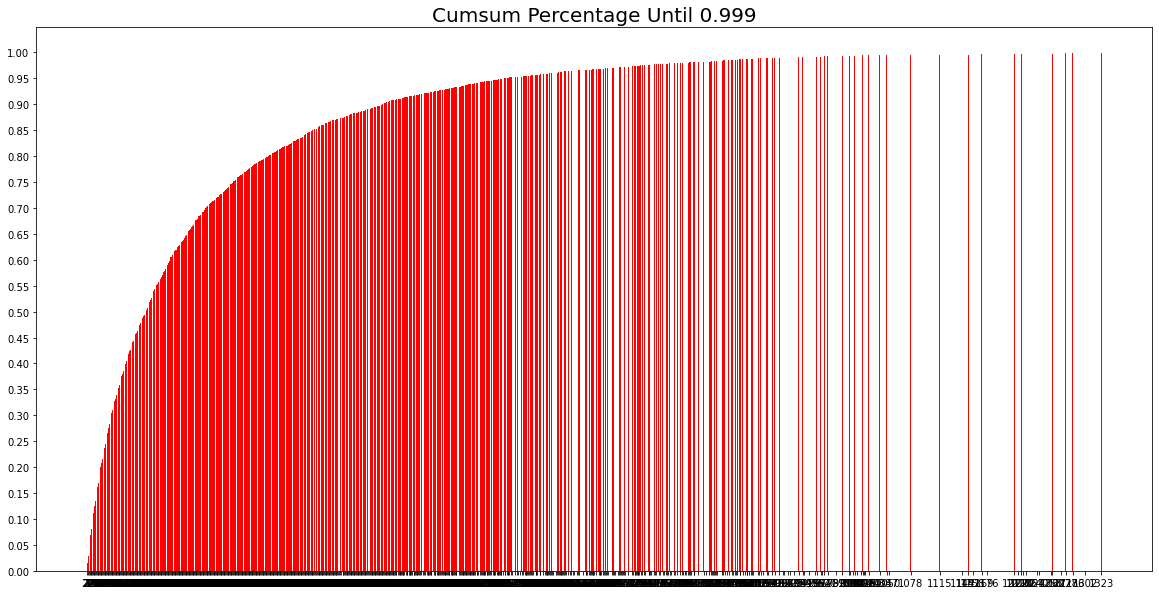

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

---
### 3-2 Time
---

In [7]:
def int_to_time(x):
    x = pd.to_datetime(time.strftime('%Y-%m-%d %I:%M:%S', time.gmtime(x)))
    return x

In [8]:
data['Time']=data['Time'].apply(int_to_time)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 10:00:19
22,1,1270,5,2000-12-31 10:00:55
27,1,1721,4,2000-12-31 10:00:55
37,1,1022,5,2000-12-31 10:00:55
24,1,2340,3,2000-12-31 10:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 02:40:29
999988,6040,1921,4,2001-08-10 02:41:04
1000172,6040,1784,3,2001-08-10 02:41:04
1000167,6040,161,3,2001-08-10 02:41:26


In [10]:
data['Time'].sort_values()

1000138   2000-04-25 11:05:32
1000153   2000-04-25 11:05:54
999873    2000-04-25 11:05:54
1000007   2000-04-25 11:06:17
1000192   2000-04-25 11:06:17
                  ...        
825438    2003-02-28 05:47:23
825731    2003-02-28 05:49:08
825724    2003-02-28 05:49:08
825603    2003-02-28 05:49:50
511804    2003-02-28 12:51:39
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [23]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 11:05:32
2003-02-28 12:51:39


2000년 4월 부터 2003년 2월 까지의 약 3년 가량의 데이터 셋인듯 하다.

---
# 4. 데이터셋 나누기
---

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [32]:
tr, test = split_by_date(data, n_days=250)
tr, val = split_by_date(tr, n_days=250)

In [35]:
print('train 데이터셋 길이 :',len(tr))
print('test 데이터셋 길이 :',len(test))
print('valid 데이터셋 길이 :',len(val))

train 데이터셋 길이 : 761365
test 데이터셋 길이 : 160111
valid 데이터셋 길이 : 78678


In [49]:
total_len = len(tr) + len(test) +len(val)

In [44]:
print('train 데이터셋 비율 :','{:.4}'.format((len(tr) / total_len) * 100))
print('test 데이터셋 비율 :','{:.4}'.format((len(test) / total_len) * 100))
print('val 데이터셋 비율 :','{:.3}'.format((len(val) / total_len) * 100))

train 데이터셋 비율 : 76.12
test 데이터셋 비율 : 16.01
val 데이터셋 비율 : 7.87


In [47]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [48]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 761365
	 Sessions: 5377
	 Items: 3661
	 First Time : 2000-04-25 11:05:32
	 Last Time : 2001-10-16 11:22:02

* valid Set Stats Info
	 Events: 78678
	 Sessions: 262
	 Items: 3336
	 First Time : 2000-04-27 01:55:48
	 Last Time : 2002-06-23 12:05:05

* test Set Stats Info
	 Events: 160111
	 Sessions: 401
	 Items: 3396
	 First Time : 2000-04-27 04:38:08
	 Last Time : 2003-02-28 12:51:39



In [50]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [51]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

----
# 5. Data pipeline
---

In [53]:
class SessionDataset:

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [54]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 10:00:19,0
22,1,1270,5,2000-12-31 10:00:55,1
27,1,1721,4,2000-12-31 10:00:55,2
37,1,1022,5,2000-12-31 10:00:55,3
24,1,2340,3,2000-12-31 10:01:43,4
36,1,1836,5,2000-12-31 10:02:52,5
3,1,3408,4,2000-12-31 10:04:35,6
7,1,2804,5,2000-12-31 10:11:59,7
47,1,1207,4,2000-12-31 10:11:59,8
0,1,1193,5,2000-12-31 10:12:40,9


In [55]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 760901, 761024, 761365], dtype=int32)

In [56]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5374, 5375, 5376])

In [58]:
class SessionDataLoader:

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [59]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 10:00:19,0
22,1,1270,5,2000-12-31 10:00:55,1
27,1,1721,4,2000-12-31 10:00:55,2
37,1,1022,5,2000-12-31 10:00:55,3
24,1,2340,3,2000-12-31 10:01:43,4
36,1,1836,5,2000-12-31 10:02:52,5
3,1,3408,4,2000-12-31 10:04:35,6
7,1,2804,5,2000-12-31 10:11:59,7
47,1,1207,4,2000-12-31 10:11:59,8
0,1,1193,5,2000-12-31 10:12:40,9


In [60]:
iter_ex = iter(tr_data_loader)

In [61]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


---
# 6. Modeling
---

- Recall은 유저가 관심있는 전체 아이템 가운데 실제 추천한 아이템 비율

- MRR은 정답 아이템이 나온 순번의 역수 값  
정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고,  
뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것

In [62]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [64]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [65]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

- hsz = GRU Layer의 Unit(출력 공간의 차원)
- k = 예측 갯수 

In [81]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1, 3661)]           0         
                                                                 
 GRU (GRU)                   [(64, 50),                556950    
                              (64, 50)]                          
                                                                 
 dropout_2 (Dropout)         (64, 50)                  0         
                                                                 
 dense_2 (Dense)             (64, 3661)                186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [80]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items) # to_categorical = 원-핫 인코딩 
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        
        history['Recall'].append(val_recall)
        history['MRR'].append(val_mrr)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [82]:
history = {'Recall': [] , 'MRR': []}

train_model(model, args)

Evaluation:  81%|████████  | 989/1225 [10:38<02:32,  1.55it/s]


	 - Recall@20 epoch 1: 0.213394
	 - MRR@20    epoch 1: 0.054563



Evaluation:  81%|████████  | 989/1225 [09:06<02:10,  1.81it/s]


	 - Recall@20 epoch 2: 0.264124
	 - MRR@20    epoch 2: 0.073439



Evaluation:  81%|████████  | 989/1225 [08:57<02:08,  1.84it/s]


	 - Recall@20 epoch 3: 0.281945
	 - MRR@20    epoch 3: 0.080858



Evaluation:  81%|████████  | 989/1225 [08:57<02:08,  1.84it/s]


	 - Recall@20 epoch 4: 0.290461
	 - MRR@20    epoch 4: 0.085432



Evaluation:  81%|████████  | 989/1225 [08:56<02:08,  1.84it/s]

	 - Recall@20 epoch 5: 0.293478
	 - MRR@20    epoch 5: 0.087499



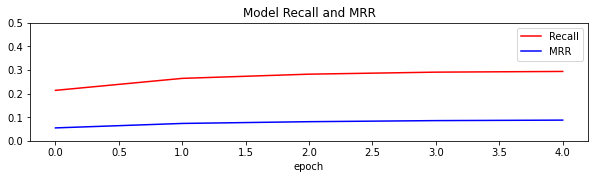

In [90]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('Model Recall and MRR')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

5번의 epoch을 돌린 결과 초반에 증가 추세를 보이다  
더 이상 증가하지 않고 0.3 정도의 recall과 0.1정도의 MRR에 수렴하는 것 처럼 보인다.

In [92]:
test_history_batch = {'test_recall':[],'test_mrr':[]}

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
    
    test_history_batch['test_recall'].append(test_recall)
    test_history_batch['test_mrr'].append(test_mrr)

test_model(model, args, test)

Evaluation:  89%|████████▊ | 2209/2495 [20:34<02:39,  1.79it/s]

	 - Recall@20: 0.264387
	 - MRR@20: 0.077760



----
# 7. 성능 개선해보기
---

---
### 7-1 batchsize 바꿔보기
---

- 기존 64에서 128로 증가

In [93]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(128, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               556950    
                              (128, 50)]                         
                                                                 
 dropout_3 (Dropout)         (128, 50)                 0         
                                                                 
 dense_3 (Dense)             (128, 3661)               186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = {'Recall': [] , 'MRR': []}

train_model(model2, args2)

Evaluation:  58%|█████▊    | 352/612 [06:29<04:47,  1.11s/it]


	 - Recall@20 epoch 1: 0.201394
	 - MRR@20    epoch 1: 0.050674



Evaluation:  58%|█████▊    | 352/612 [06:16<04:38,  1.07s/it]


	 - Recall@20 epoch 2: 0.264094
	 - MRR@20    epoch 2: 0.071645



Evaluation:  58%|█████▊    | 352/612 [06:11<04:34,  1.05s/it]


	 - Recall@20 epoch 3: 0.292614
	 - MRR@20    epoch 3: 0.083317



Evaluation:  58%|█████▊    | 352/612 [06:07<04:31,  1.04s/it]


	 - Recall@20 epoch 4: 0.307662
	 - MRR@20    epoch 4: 0.090277



Evaluation:  58%|█████▊    | 352/612 [06:04<04:29,  1.04s/it]

	 - Recall@20 epoch 5: 0.314009
	 - MRR@20    epoch 5: 0.094770



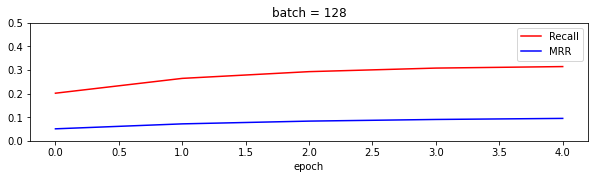

In [95]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('batch = 128')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

이전과 비슷하지만 그래프 및 수치상으로 epoch이 증가할 수록 수치가 증가하는 모습을 보이고 있다.

In [96]:
test_model(model2, args2, test)

Evaluation:  76%|███████▋  | 951/1247 [16:54<05:15,  1.07s/it]

	 - Recall@20: 0.270119
	 - MRR@20: 0.078182



---
### 7-2 batchsize 바꿔보기
---

- batch 128 -> 256

In [108]:
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               556950    
                              (256, 50)]                         
                                                                 
 dropout_4 (Dropout)         (256, 50)                 0         
                                                                 
 dense_4 (Dense)             (256, 3661)               186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = {'Recall': [] , 'MRR': []}

train_model(model3, args3)

Evaluation:   9%|▉         | 27/306 [01:00<10:24,  2.24s/it]


	 - Recall@20 epoch 1: 0.161748
	 - MRR@20    epoch 1: 0.043139



Evaluation:   9%|▉         | 27/306 [00:55<09:36,  2.07s/it]


	 - Recall@20 epoch 2: 0.275897
	 - MRR@20    epoch 2: 0.079607



Evaluation:   9%|▉         | 27/306 [00:54<09:22,  2.02s/it]


	 - Recall@20 epoch 3: 0.316117
	 - MRR@20    epoch 3: 0.097225



Evaluation:   9%|▉         | 27/306 [00:53<09:10,  1.97s/it]


	 - Recall@20 epoch 4: 0.340278
	 - MRR@20    epoch 4: 0.109697



Evaluation:   9%|▉         | 27/306 [00:52<08:59,  1.94s/it]

	 - Recall@20 epoch 5: 0.349971
	 - MRR@20    epoch 5: 0.116976



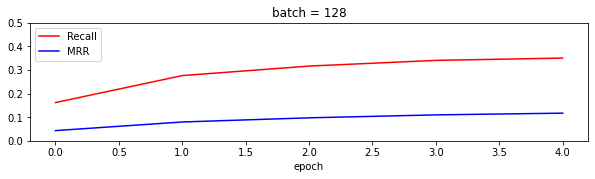

In [110]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('batch = 128')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

배치 사이즈를 키운 결과 소요시간은 감소하였고, 수치도 증가하는 추세를 보이고 있다.  
다만, evaliatuin의 과정이 모두 진행되지 않고, test 과정 또한 전체 진행되고 있지 않는다.  

In [111]:
test_model(model3, args3, test)

Evaluation:  49%|████▉     | 308/623 [10:28<10:43,  2.04s/it]

	 - Recall@20: 0.298181
	 - MRR@20: 0.086277



---
### 7-3 leraning_Rate 바꿔보기
---

- 배치 사이즈 = 256을 기본으로 사용 
- lr = 0.001 -> 0.0001로 변경 
- drop_rate = 0.1 -> 0.3로 변경 

In [113]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.0001, epochs=5, k=20)
model4 = create_model(args4)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               556950    
                              (256, 50)]                         
                                                                 
 dropout_5 (Dropout)         (256, 50)                 0         
                                                                 
 dense_5 (Dense)             (256, 3661)               186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = {'Recall': [] , 'MRR': []}

train_model(model4, args4)

Evaluation:   9%|▉         | 27/306 [01:04<11:01,  2.37s/it]


	 - Recall@20 epoch 1: 0.131221
	 - MRR@20    epoch 1: 0.028877



Evaluation:   9%|▉         | 27/306 [01:00<10:27,  2.25s/it]


	 - Recall@20 epoch 2: 0.133102
	 - MRR@20    epoch 2: 0.029693



Evaluation:   9%|▉         | 27/306 [01:01<10:32,  2.27s/it]


	 - Recall@20 epoch 3: 0.133102
	 - MRR@20    epoch 3: 0.029727



Evaluation:   9%|▉         | 27/306 [01:27<15:04,  3.24s/it]


	 - Recall@20 epoch 4: 0.131076
	 - MRR@20    epoch 4: 0.029726



Evaluation:   9%|▉         | 27/306 [01:02<10:50,  2.33s/it]

	 - Recall@20 epoch 5: 0.128038
	 - MRR@20    epoch 5: 0.027451



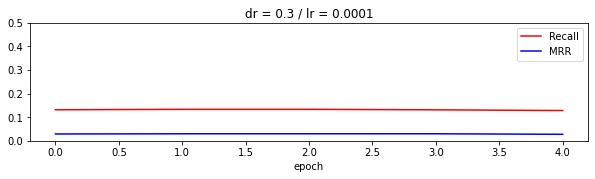

In [115]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('dr = 0.3 / lr = 0.0001')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

In [116]:
test_model(model4, args4, test)

Evaluation:  49%|████▉     | 308/623 [12:07<12:24,  2.36s/it]

	 - Recall@20: 0.056767
	 - MRR@20: 0.010864



수치가 변하지 않고 일정하게 수렴하고 있다.  
이상적인 설정값은 안니 것 같다.

---
### 7-4 leraning_Rate 바꿔보기
---

- 배치 사이즈 = 256을 기본으로 사용 
- 기존 lr = 0.001 -> 0.01로 변경 
- drop_rate = 0.1 -> 0.3로 변경 

In [117]:
args5 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.01, epochs=5, k=20)
model5 = create_model(args5)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               556950    
                              (256, 50)]                         
                                                                 
 dropout_6 (Dropout)         (256, 50)                 0         
                                                                 
 dense_6 (Dense)             (256, 3661)               186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [118]:
history = {'Recall': [] , 'MRR': []}

train_model(model5, args5)

Evaluation:   9%|▉         | 27/306 [00:58<10:08,  2.18s/it]


	 - Recall@20 epoch 1: 0.305266
	 - MRR@20    epoch 1: 0.095536



Evaluation:   9%|▉         | 27/306 [00:54<09:18,  2.00s/it]


	 - Recall@20 epoch 2: 0.319010
	 - MRR@20    epoch 2: 0.105066



Evaluation:   9%|▉         | 27/306 [00:53<09:16,  2.00s/it]


	 - Recall@20 epoch 3: 0.326678
	 - MRR@20    epoch 3: 0.103347



Evaluation:   9%|▉         | 27/306 [00:54<09:24,  2.02s/it]


	 - Recall@20 epoch 4: 0.329572
	 - MRR@20    epoch 4: 0.107534



Evaluation:   9%|▉         | 27/306 [00:53<09:13,  1.98s/it]

	 - Recall@20 epoch 5: 0.331308
	 - MRR@20    epoch 5: 0.106262



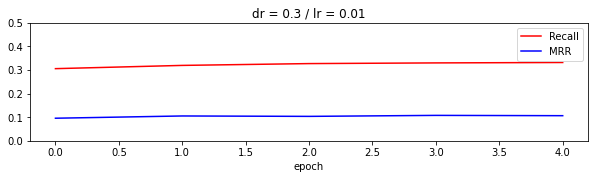

In [119]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('dr = 0.3 / lr = 0.01')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

recall 값이 이전보다 올라가는 있으나 epoch별로 크게 변화가 없으며,  
이전의 시도들 보다 좋아졌다고 보기 어렵다.

In [120]:
test_model(model5, args5, test)

Evaluation:  49%|████▉     | 308/623 [11:14<11:29,  2.19s/it]

	 - Recall@20: 0.283660
	 - MRR@20: 0.080148



---
### 7-5 leraning_Rate 바꿔보기
---

- 배치 사이즈 = 256을 기본으로 사용 
- 이전 lr = 0.01 -> 0.1로 변경 
- drop_rate = 0.3

In [124]:
args6 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.1, epochs=5, k=20)
model6 = create_model(args6)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               556950    
                              (256, 50)]                         
                                                                 
 dropout_7 (Dropout)         (256, 50)                 0         
                                                                 
 dense_7 (Dense)             (256, 3661)               186711    
                                                                 
Total params: 743,661
Trainable params: 743,661
Non-trainable params: 0
_________________________________________________________________


In [125]:
history = {'Recall': [] , 'MRR': []}

train_model(model6, args6)

Evaluation:   9%|▉         | 27/306 [01:02<10:48,  2.33s/it]


	 - Recall@20 epoch 1: 0.094618
	 - MRR@20    epoch 1: 0.021417



Evaluation:   9%|▉         | 27/306 [01:02<10:42,  2.30s/it]


	 - Recall@20 epoch 2: 0.102575
	 - MRR@20    epoch 2: 0.023113



Evaluation:   9%|▉         | 27/306 [01:02<10:42,  2.30s/it]


	 - Recall@20 epoch 3: 0.108652
	 - MRR@20    epoch 3: 0.025461



Evaluation:   9%|▉         | 27/306 [01:02<10:45,  2.31s/it]


	 - Recall@20 epoch 4: 0.103588
	 - MRR@20    epoch 4: 0.022539



Evaluation:   9%|▉         | 27/306 [01:01<10:38,  2.29s/it]

	 - Recall@20 epoch 5: 0.105903
	 - MRR@20    epoch 5: 0.024000



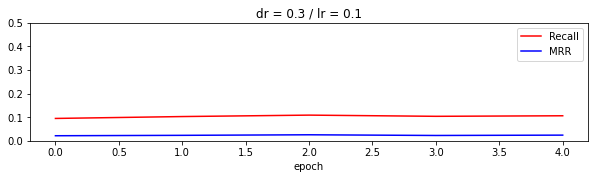

In [126]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('dr = 0.3 / lr = 0.1')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

다시 수치가 떨어졌다.  
적절한 값을 찾는 것이 역시나 어렵다.

In [127]:
test_model(model6, args6, test)

Evaluation:  49%|████▉     | 308/623 [12:24<12:41,  2.42s/it]

	 - Recall@20: 0.078455
	 - MRR@20: 0.016655



- 현재까지 시도들의 test값을 시각적으로 표현한 그래프이다.

---
### 7-6 전체 Test 수치 한 눈에 보기
---

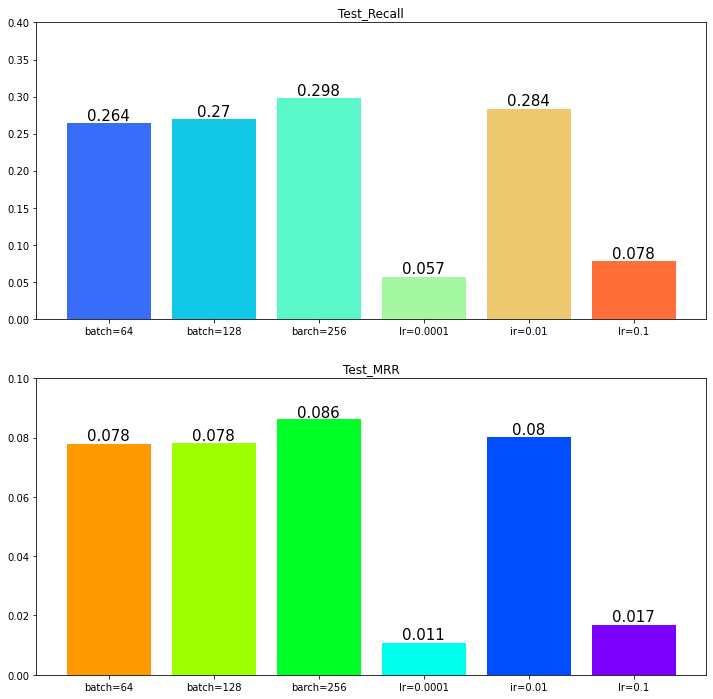

In [160]:
import seaborn as sns

name = ['batch=64','batch=128','barch=256','lr=0.0001','ir=0.01','lr=0.1']

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.ylim(0,0.4)
plt.title('Test_Recall')
colors = sns.color_palette('rainbow',len(name)) ## 색상 지정
plt.bar(name,test_history_batch['test_recall'],color = colors)

for i, v in enumerate(name):
    plt.text(v, round(test_history_batch['test_recall'][i],3), round(test_history_batch['test_recall'][i],3), # 좌표(x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')    

plt.subplot(2,1,2)
plt.ylim(0,0.1)
colors = sns.color_palette('gist_rainbow',len(name)) ## 색상 지정
plt.bar(name,test_history_batch['test_mrr'],color = colors)
plt.title('Test_MRR')
for i, v in enumerate(name):
    plt.text(v, round(test_history_batch['test_mrr'][i],3), round(test_history_batch['test_mrr'][i],3), # 좌표(x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')  

지금까지의 결과를 보면 batch = 256 / lr = 0.001 / drop_rate = 0.1이 가장 높은 수치값을 가지고 있다.

---
### 7-7 GRU units의 수 늘려보기 (hsz)
---

- 이전까지 가장 좋았던 수치를 그대로 사용 
- hsz값 50 -> 100

In [161]:
args7 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model7 = create_model(args7)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 100),              1128900   
                              (256, 100)]                        
                                                                 
 dropout_8 (Dropout)         (256, 100)                0         
                                                                 
 dense_8 (Dense)             (256, 3661)               369761    
                                                                 
Total params: 1,498,661
Trainable params: 1,498,661
Non-trainable params: 0
_________________________________________________________________


In [162]:
history = {'Recall': [] , 'MRR': []}

train_model(model7, args7)

Evaluation:   9%|▉         | 27/306 [00:58<10:02,  2.16s/it]


	 - Recall@20 epoch 1: 0.246238
	 - MRR@20    epoch 1: 0.074880



Evaluation:   9%|▉         | 27/306 [00:54<09:27,  2.03s/it]


	 - Recall@20 epoch 2: 0.309028
	 - MRR@20    epoch 2: 0.098453



Evaluation:   9%|▉         | 27/306 [00:54<09:21,  2.01s/it]


	 - Recall@20 epoch 3: 0.343895
	 - MRR@20    epoch 3: 0.113632



Evaluation:   9%|▉         | 27/306 [00:53<09:10,  1.97s/it]


	 - Recall@20 epoch 4: 0.358652
	 - MRR@20    epoch 4: 0.122229



Evaluation:   9%|▉         | 27/306 [00:52<09:02,  1.94s/it]

	 - Recall@20 epoch 5: 0.364728
	 - MRR@20    epoch 5: 0.128749



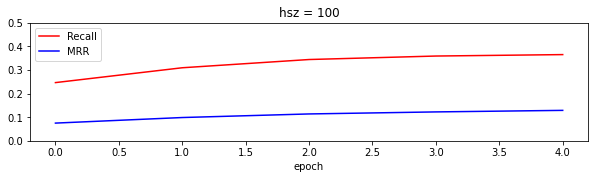

In [163]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('hsz = 100')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

값이 점차 증가하는 추세를 보이며, 이전 보다 더 좋은 수치를 보이는 것 같다.

In [164]:
test_model(model7, args7, test)

Evaluation:  49%|████▉     | 308/623 [10:35<10:49,  2.06s/it]

	 - Recall@20: 0.315252
	 - MRR@20: 0.095987



---
### 7-8 GRU units의 수 늘려보기 (hsz)
---

- 이전까지 가장 좋았던 수치를 그대로 사용 
- hsz값 100 -> 150

In [166]:
args8 = Args(tr, val, test, batch_size=256, hsz=150, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model8 = create_model(args8)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 150),              1715850   
                              (256, 150)]                        
                                                                 
 dropout_9 (Dropout)         (256, 150)                0         
                                                                 
 dense_9 (Dense)             (256, 3661)               552811    
                                                                 
Total params: 2,268,661
Trainable params: 2,268,661
Non-trainable params: 0
_________________________________________________________________


In [167]:
history = {'Recall': [] , 'MRR': []}

train_model(model8, args8)

Evaluation:   9%|▉         | 27/306 [00:56<09:44,  2.10s/it]


	 - Recall@20 epoch 1: 0.266348
	 - MRR@20    epoch 1: 0.083186



Evaluation:   9%|▉         | 27/306 [00:53<09:13,  1.98s/it]


	 - Recall@20 epoch 2: 0.330729
	 - MRR@20    epoch 2: 0.111623



Evaluation:   9%|▉         | 27/306 [00:52<09:05,  1.96s/it]


	 - Recall@20 epoch 3: 0.357928
	 - MRR@20    epoch 3: 0.122099



Evaluation:   9%|▉         | 27/306 [00:53<09:07,  1.96s/it]


	 - Recall@20 epoch 4: 0.360966
	 - MRR@20    epoch 4: 0.126152



Evaluation:   9%|▉         | 27/306 [00:52<08:58,  1.93s/it]

	 - Recall@20 epoch 5: 0.364149
	 - MRR@20    epoch 5: 0.130325



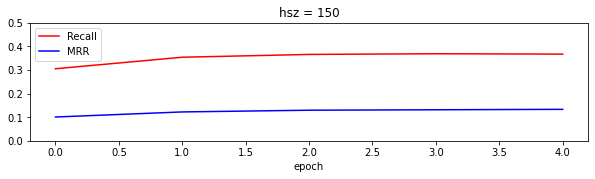

In [178]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('hsz = 150')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

100으로 설정했을 떄 보다 수치가 더 좋아지는 느낌이다.

In [169]:
test_model(model8, args8, test)

Evaluation:  49%|████▉     | 308/623 [10:30<10:44,  2.05s/it]

	 - Recall@20: 0.322710
	 - MRR@20: 0.099035



---
### 7-9 GRU units의 수 늘려보기 (hsz)
---

- 이전까지 가장 좋았던 수치를 그대로 사용 
- hsz값 150 -> 300

In [171]:
args9 = Args(tr, val, test, batch_size=256, hsz=300, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model9 = create_model(args9)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 300),              3566700   
                              (256, 300)]                        
                                                                 
 dropout_10 (Dropout)        (256, 300)                0         
                                                                 
 dense_10 (Dense)            (256, 3661)               1101961   
                                                                 
Total params: 4,668,661
Trainable params: 4,668,661
Non-trainable params: 0
_________________________________________________________________


In [172]:
history = {'Recall': [] , 'MRR': []}

train_model(model9, args9)

Evaluation:   9%|▉         | 27/306 [00:55<09:38,  2.07s/it]


	 - Recall@20 epoch 1: 0.304832
	 - MRR@20    epoch 1: 0.100682



Evaluation:   9%|▉         | 27/306 [00:53<09:16,  1.99s/it]


	 - Recall@20 epoch 2: 0.353588
	 - MRR@20    epoch 2: 0.122129



Evaluation:   9%|▉         | 27/306 [00:52<09:02,  1.95s/it]


	 - Recall@20 epoch 3: 0.365451
	 - MRR@20    epoch 3: 0.129433



Evaluation:   9%|▉         | 27/306 [00:52<08:58,  1.93s/it]


	 - Recall@20 epoch 4: 0.368345
	 - MRR@20    epoch 4: 0.131314



Evaluation:   9%|▉         | 27/306 [00:52<09:02,  1.94s/it]

	 - Recall@20 epoch 5: 0.366753
	 - MRR@20    epoch 5: 0.133114



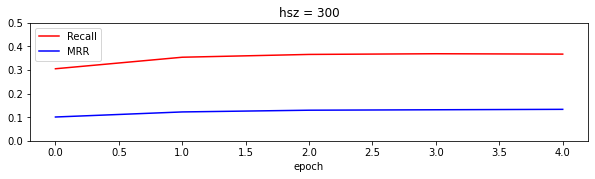

In [177]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('hsz = 300')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

hsz를 150으로 두나 300으로 두나 크게 차이가 없는 것 처럼 보인다.

In [174]:
test_model(model9, args9, test)

Evaluation:  49%|████▉     | 308/623 [10:32<10:46,  2.05s/it]

	 - Recall@20: 0.322595
	 - MRR@20: 0.098703



---
### 7-10 전체 Test 수치 한 눈에 보기
---

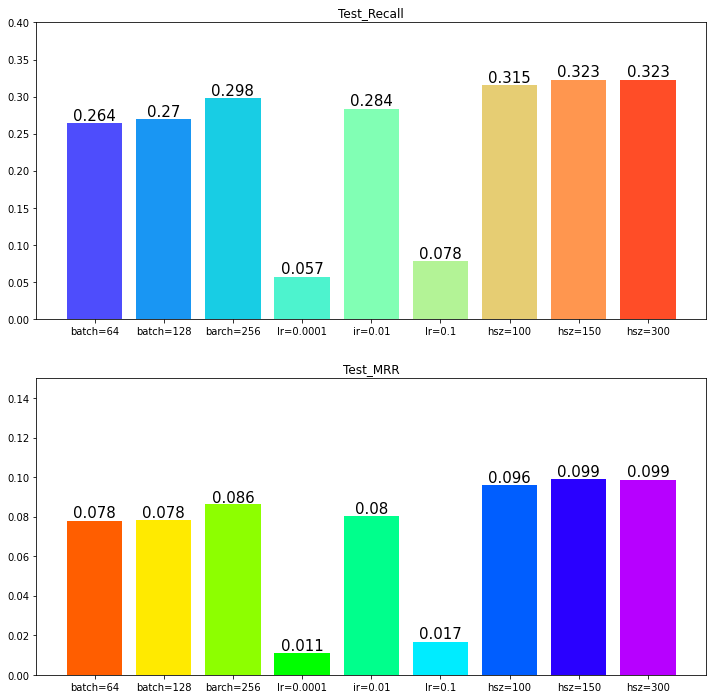

In [179]:
name = ['batch=64','batch=128','barch=256','lr=0.0001','ir=0.01','lr=0.1','hsz=100','hsz=150','hsz=300']

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.ylim(0,0.4)
plt.title('Test_Recall')
colors = sns.color_palette('rainbow',len(name)) ## 색상 지정
plt.bar(name,test_history_batch['test_recall'],color = colors)

for i, v in enumerate(name):
    plt.text(v, round(test_history_batch['test_recall'][i],3), round(test_history_batch['test_recall'][i],3), # 좌표(x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')    

plt.subplot(2,1,2)
plt.ylim(0,0.15)
colors = sns.color_palette('gist_rainbow',len(name)) ## 색상 지정
plt.bar(name,test_history_batch['test_mrr'],color = colors)
plt.title('Test_MRR')
for i, v in enumerate(name):
    plt.text(v, round(test_history_batch['test_mrr'][i],3), round(test_history_batch['test_mrr'][i],3), # 좌표(x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='black',
             horizontalalignment='center',  
             verticalalignment='bottom')  

test한 결과물로 batch = 256 / lr = 0.001 / hsz = 150으로 둔 후  
epoch을 더 늘려 수치가 증가하는지 확인해 보겠다.

---
### 7-11 epoch 늘려보기
---

- epoch = 5 -> 20으로 

In [180]:
args10 = Args(tr, val, test, batch_size=256, hsz=150, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model10 = create_model(args10)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(256, 1, 3661)]          0         
                                                                 
 GRU (GRU)                   [(256, 150),              1715850   
                              (256, 150)]                        
                                                                 
 dropout_11 (Dropout)        (256, 150)                0         
                                                                 
 dense_11 (Dense)            (256, 3661)               552811    
                                                                 
Total params: 2,268,661
Trainable params: 2,268,661
Non-trainable params: 0
_________________________________________________________________


In [181]:
history = {'Recall': [] , 'MRR': []}

train_model(model10, args10)

Evaluation:   9%|▉         | 27/306 [01:01<10:30,  2.26s/it]


	 - Recall@20 epoch 1: 0.268229
	 - MRR@20    epoch 1: 0.083090



Evaluation:   9%|▉         | 27/306 [00:53<09:13,  1.98s/it]


	 - Recall@20 epoch 2: 0.329282
	 - MRR@20    epoch 2: 0.108797



Evaluation:   9%|▉         | 27/306 [00:54<09:22,  2.02s/it]


	 - Recall@20 epoch 3: 0.350984
	 - MRR@20    epoch 3: 0.120786



Evaluation:   9%|▉         | 27/306 [00:53<09:13,  1.98s/it]


	 - Recall@20 epoch 4: 0.358362
	 - MRR@20    epoch 4: 0.128216



Evaluation:   9%|▉         | 27/306 [00:53<09:12,  1.98s/it]


	 - Recall@20 epoch 5: 0.368779
	 - MRR@20    epoch 5: 0.133670



Evaluation:   9%|▉         | 27/306 [00:52<08:59,  1.93s/it]


	 - Recall@20 epoch 6: 0.371528
	 - MRR@20    epoch 6: 0.135182



Evaluation:   9%|▉         | 27/306 [00:51<08:52,  1.91s/it]


	 - Recall@20 epoch 7: 0.378038
	 - MRR@20    epoch 7: 0.135742



Evaluation:   9%|▉         | 27/306 [00:51<08:55,  1.92s/it]


	 - Recall@20 epoch 8: 0.378038
	 - MRR@20    epoch 8: 0.136343



Evaluation:   9%|▉         | 27/306 [00:51<08:52,  1.91s/it]


	 - Recall@20 epoch 9: 0.372541
	 - MRR@20    epoch 9: 0.135062



Evaluation:   9%|▉         | 27/306 [00:52<08:58,  1.93s/it]


	 - Recall@20 epoch 10: 0.371528
	 - MRR@20    epoch 10: 0.134701



Evaluation:   9%|▉         | 27/306 [00:51<08:52,  1.91s/it]


	 - Recall@20 epoch 11: 0.371528
	 - MRR@20    epoch 11: 0.134900



Evaluation:   9%|▉         | 27/306 [00:51<08:55,  1.92s/it]


	 - Recall@20 epoch 12: 0.369647
	 - MRR@20    epoch 12: 0.132994



Evaluation:   9%|▉         | 27/306 [00:52<09:01,  1.94s/it]


	 - Recall@20 epoch 13: 0.370081
	 - MRR@20    epoch 13: 0.134189



Evaluation:   9%|▉         | 27/306 [00:51<08:54,  1.92s/it]


	 - Recall@20 epoch 14: 0.370515
	 - MRR@20    epoch 14: 0.134015



Evaluation:   9%|▉         | 27/306 [00:51<08:55,  1.92s/it]


	 - Recall@20 epoch 15: 0.367332
	 - MRR@20    epoch 15: 0.132364



Evaluation:   9%|▉         | 27/306 [00:52<08:57,  1.93s/it]


	 - Recall@20 epoch 16: 0.369647
	 - MRR@20    epoch 16: 0.133275



Evaluation:   9%|▉         | 27/306 [00:52<09:01,  1.94s/it]


	 - Recall@20 epoch 17: 0.368924
	 - MRR@20    epoch 17: 0.132111



Evaluation:   9%|▉         | 27/306 [00:53<09:09,  1.97s/it]


	 - Recall@20 epoch 18: 0.368200
	 - MRR@20    epoch 18: 0.132722



Evaluation:   9%|▉         | 27/306 [00:52<09:07,  1.96s/it]


	 - Recall@20 epoch 19: 0.365741
	 - MRR@20    epoch 19: 0.132113



Evaluation:   9%|▉         | 27/306 [00:52<09:00,  1.94s/it]

	 - Recall@20 epoch 20: 0.366609
	 - MRR@20    epoch 20: 0.132839



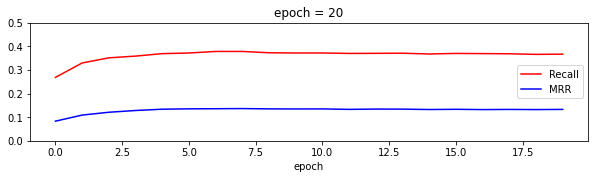

In [182]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(history['Recall'], 'red')
plt.plot(history['MRR'], 'blue')
plt.title('epoch = 20')
plt.xlabel('epoch')
plt.ylim(0,0.5)
plt.legend(['Recall','MRR'],loc='best')

epoch을 늘리면 수치 값들이 증가할 것이라 예상하였으나,  
일정 수준 까지 올라가면 변화가 없거나 조금씩 떨어지는 모습을 볼 수 있다.

In [183]:
test_model(model10, args10, test)

Evaluation:  49%|████▉     | 308/623 [10:28<10:42,  2.04s/it]

	 - Recall@20: 0.306133
	 - MRR@20: 0.094735



---
# 8. 회고
---

- 예제에서는 클릭률을 기반으로 하는 데이터셋으로 SessionID가 1일 때 오류로 확인할 수 있으나,  
지금 데이터셋은 UserId를 SessionId의 역할을 하는 것으로 예제와 동일하게 1일때 제거하는 것은 오류가 있다고 판단하여 제거 하지 않았다.
- 또한, 예제에서 30일 기준으로 데이터셋을 잘랐으나, 나는 모든 데이터셋을 사용하였다. 
- 각종 값들을 바꿔본 결과 수치적 증가를 위해서는 batch_size / hsz / learning_rate의 값을 조절하는 것이 중요한 것 같다.
- 특히 learning_rate를 변경해본 결과 수치적으로 엄청난 차이를 보이며, accuracy가 0으로 나오는 등 큰 영향을 미치는 것 같다.

- 이전의 추천 시스템에서는 유사도를 통해 영화명을 직접 눈으로 확인하는 과정을 거쳤으나,  
지금의 프로젝트에서는 GRU를 통한 데이터 학습과 recall, mrr과 같은 값으로만 데이터셋을 확인하는 과정을 거치고 있다. 
- 이전과 달리 수치적 명확한 기준이 있는 점은 긍정적이나,  
추천 시스템에 걸맞게 어떤 영화를 추천하는지 리스트를 볼 수 있다면 더 재밌는 프로젝트가 되었을 것 같다.
- 모델 학습 및 평가를 하다보면 evaluation의 진행률이 끝까지 가지 않고 끝나는 것을 볼 수 있다.  
아마 batch_size의 영향인 듯 싶은데 정확한 원인은 알아내지 못 하였다.